# Evaluación - Redes Convolucionales

**Autor:**Erwin Nuñez - Luis Saez

**Fecha de Creación:** Mayo de 2025

**Versión:** 1.0  

---

## Descripción

Este notebook contiene el desarrollo de la entrega 2 de la asignatura optativa de Deep Learning de DuocUC Sede Concepción

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.9. A continuación se listan las bibliotecas necesarias:

- tensorflow (2.18.0)

Para verificar la versión instalada ejecutar usando el siguiente comando, usando la librería de la cual quieres saber la versión:

```bash
import tensorflow as tf
print(tf.__version__)
````

# Entregable

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en el informe:

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas al modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, entre otras.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

✅ **Notas**
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que el modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como se ha hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

# Preparación del entorno

In [ ]:
import cv2, os, pprint
import numpy as np
import keras
import glob
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import collections
import tensorflow as tf
import itertools

import keras
from google.colab.patches import cv2_imshow
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.models import Sequential
from keras.layers import Input, Dense, Activation , Dropout, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam, SGD, Adadelta
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.python.keras import backend as keras_backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import random
from tensorflow.keras.initializers import Constant

In [ ]:
def load_train_set(dirname : str, map_characters : np.array, verbose=True):
    """Esta función carga los datos de training en imágenes.

    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.

    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas

    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

def load_test_set(dirname : str, map_characters : np.array, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)

In [ ]:
!wget -O simpsons_train.tar.gz https://www.dropbox.com/scl/fi/qkg3gs31xjbhv9jjqmot6/simpsons_train.tar.gz?rlkey=oqbofdqoqjrpmxjwxaphru0yr&st=b96sg8iu&dl=0
!wget -O simpsons_test.tar.gz https://www.dropbox.com/scl/fi/zche5dm3zgd9jysatnmka/simpsons_test.tar.gz?rlkey=iek183gc4t4w9mdnz1izhudni&st=qau98qns&dl=0
!tar -xzvf simpsons_train.tar.gz
!tar -xzvf simpsons_test.tar.gz

Se truncaron las últimas líneas 5000 del resultado de transmisión.
simpsons/sideshow_bob/pic_0507.jpg
simpsons/sideshow_bob/pic_0365.jpg
simpsons/moe_szyslak/pic_0309.jpg
simpsons/ned_flanders/pic_0034.jpg
simpsons/sideshow_bob/pic_0704.jpg
simpsons/sideshow_bob/pic_0562.jpg
simpsons/marge_simpson/pic_0777.jpg
simpsons/moe_szyslak/pic_0506.jpg
simpsons/moe_szyslak/pic_0364.jpg
simpsons/comic_book_guy/pic_0439.jpg
simpsons/comic_book_guy/pic_0297.jpg
simpsons/ned_flanders/pic_0231.jpg
simpsons/moe_szyslak/pic_0561.jpg
simpsons/charles_montgomery_burns/pic_1133.jpg
simpsons/cletus_spuckler/pic_0037.jpg
simpsons/ned_flanders/pic_0831.jpg
simpsons/gil/pic_0018.jpg
simpsons/ned_flanders/pic_1148.jpg
simpsons/principal_skinner/pic_0439.jpg
simpsons/ned_flanders/pic_1345.jpg
simpsons/abraham_grampa_simpson/pic_0033.jpg
simpsons/principal_skinner/pic_0636.jpg
simpsons/principal_skinner/pic_0494.jpg
simpsons/bart_simpson/pic_1141.jpg
simpsons/abraham_grampa_simpson/pic_0230.jpg
simpsons/sidesho

# Introducción

En el presente trabajo se desarrolla un modelo de Deep Learning con el objetivo de clasificar imágenes de personajes de la serie animada Los Simpsons. Para ello, se utilizarán técnicas de aprendizaje profundo aplicadas al reconocimiento de imágenes, buscando que el modelo sea capaz de identificar correctamente a los distintos personajes presentes en el conjunto de datos. Este proyecto combina aspectos de procesamiento de imágenes, redes neuronales convolucionales (CNN) y técnicas de aumento de datos (Data Augmentation) para mejorar el rendimiento y la generalización del modelo.

# Procesamiento de datos

## Preparación de datos

In [ ]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Se utilizan sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Se estandarizan todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [ ]:
# Carga los datos
DATASET_TRAIN_PATH_COLAB = "simpsons"
DATASET_TEST_PATH_COLAB = "simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_test, y_test = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


## Generacion de imagenes con DataAugmentation

In [ ]:
# Crear el generador de aumento
datagen = ImageDataGenerator(
    rotation_range=15,         # Rango moderado, más seguro para rostros y figuras
    width_shift_range=0.1,     # Pequeños desplazamientos horizontales
    height_shift_range=0.1,    # Pequeños desplazamientos verticales
    shear_range=0.05,          # Inclinaciones leves para no distorsionar caras
    zoom_range=0.1,            # Zoom leve para variar escala
    horizontal_flip=True,      # Muy útil si el personaje se ve igual al voltearse
    fill_mode='nearest'        # Mantiene continuidad visual al rellenar bordes
)

# Contar imágenes por clase
class_counts = Counter(y)
max_count = max(class_counts.values())
print("Distribución original:", class_counts)

X_augmented = []
y_augmented = []

for class_label, count in class_counts.items():
    if count < max_count:
        n_to_generate = max_count - count
        print(f"Aumentando clase {class_label} ({MAP_CHARACTERS[class_label]}): generando {n_to_generate} imágenes...")

        # Obtener solo las imágenes de esta clase
        class_indices = np.where(y == class_label)[0]
        class_images = X[class_indices]

        # Elegir imágenes aleatorias para aumentar
        for _ in range(n_to_generate):
            img = random.choice(class_images)
            img = np.expand_dims(img, axis=0)
            augmented_img = next(datagen.flow(img, batch_size=1))[0].astype('uint8')
            X_augmented.append(augmented_img)
            y_augmented.append(class_label)

# Combinar datos originales + aumentados
X = np.concatenate([X, np.array(X_augmented)], axis=0)
y = np.concatenate([y, np.array(y_augmented)], axis=0)

# Verificar nueva distribución
print("Nueva distribución balanceada:", Counter(y))

Distribución original: Counter({np.int64(7): 2246, np.int64(14): 1454, np.int64(13): 1452, np.int64(10): 1354, np.int64(2): 1342, np.int64(11): 1291, np.int64(9): 1206, np.int64(16): 1194, np.int64(3): 1193, np.int64(12): 1079, np.int64(4): 986, np.int64(0): 913, np.int64(17): 877, np.int64(1): 623, np.int64(8): 498, np.int64(5): 469, np.int64(6): 457, np.int64(15): 358})
Aumentando clase 0 (abraham_grampa_simpson): generando 1333 imágenes...
Aumentando clase 1 (apu_nahasapeemapetilon): generando 1623 imágenes...
Aumentando clase 2 (bart_simpson): generando 904 imágenes...
Aumentando clase 3 (charles_montgomery_burns): generando 1053 imágenes...
Aumentando clase 4 (chief_wiggum): generando 1260 imágenes...
Aumentando clase 5 (comic_book_guy): generando 1777 imágenes...
Aumentando clase 6 (edna_krabappel): generando 1789 imágenes...
Aumentando clase 8 (kent_brockman): generando 1748 imágenes...
Aumentando clase 9 (krusty_the_clown): generando 1040 imágenes...
Aumentando clase 10 (lisa_s

En el bloque anterior se aplicó Data Augmentation con el objetivo de balancear la cantidad de imágenes en cada una de las clases del conjunto de datos, llevándolas todas a un total de 2,246 imágenes por clase.

Cabe destacar que el Data Augmentation no genera nuevas muestras, sino que toma las existentes y aplica transformaciones, como giros, para crear versiones modificadas de la misma imagen. Esto permite aumentar la cantidad de imágenes sin alterar el contenido original, únicamente modificando aspectos como el ángulo.

## Tratamiento y separación de muestra

In [ ]:
# Se va a barajar aleatoriamente los datos. Esto es importante ya que si no
# se realiza y, por ejemplo, se escogen el 20% de los datos finales como validation
# set, se estará utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

In [ ]:
# Separa el conjunto de datos de entrenamiento en entrenamiento y validación con 20%
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=29)

# Variables con nÚmero de elementos
X_train_num_elem = X_train.shape[0]
X_val_num_elem = X_val.shape[0]
X_test_num_elem = X_test.shape[0]

# Dimensiones
img_rows = IMG_SIZE
img_cols = IMG_SIZE
img_channels = X.shape[3]

# Número de categorías
num_categ = len(MAP_CHARACTERS)

# Comprueba que efectivamente los resultados son los esperados
print("Número de imágenes de anterior training : ", X.shape[0])
print("Número de imágenes de training (80% de anterior train) : ", X_train_num_elem)
print("Número de imágenes de validación (20% de anterior train) : ", X_val_num_elem)
print("Número de imágenes de test : ", X_test_num_elem)
print("="*15)
print("Número de resultados de anterior training : ", y.shape[0])
print("Número de resultados de training (80% de anterior train) : ", y_train.shape[0])
print("Número de resultadoss de validación (20% de anterior train) : ", y_val.shape[0])
print("Número de resultados de test : ", y_test.shape[0])
print("="*15)
print("Dimensiones de training : ", X_train.shape)
print("Dimensiones de validation : ", X_val.shape)
print("Dimensiones de tests : ", X_test.shape)
print("="*15)
print("Canales de color para las imagenes : ", img_channels)
print("Resolución imágenes de anterior training : ", X.shape[1], "x", X.shape[2])
print("Resolución imágenes de training (80% de anterior train) : ", X_train.shape[1], "X", X_train.shape[2])
print("Resolución imágenes de validación (20% de anterior train) : ", X_val.shape[1], "x", X_val.shape[2])
print("Resolución imágenes de test : ", X_test.shape[1], "x", X_test.shape[2])

Número de imágenes de anterior training :  40428
Número de imágenes de training (80% de anterior train) :  32342
Número de imágenes de validación (20% de anterior train) :  8086
Número de imágenes de test :  890
Número de resultados de anterior training :  40428
Número de resultados de training (80% de anterior train) :  32342
Número de resultadoss de validación (20% de anterior train) :  8086
Número de resultados de test :  890
Dimensiones de training :  (32342, 64, 64, 3)
Dimensiones de validation :  (8086, 64, 64, 3)
Dimensiones de tests :  (890, 64, 64, 3)
Canales de color para las imagenes :  3
Resolución imágenes de anterior training :  64 x 64
Resolución imágenes de training (80% de anterior train) :  64 X 64
Resolución imágenes de validación (20% de anterior train) :  64 x 64
Resolución imágenes de test :  64 x 64


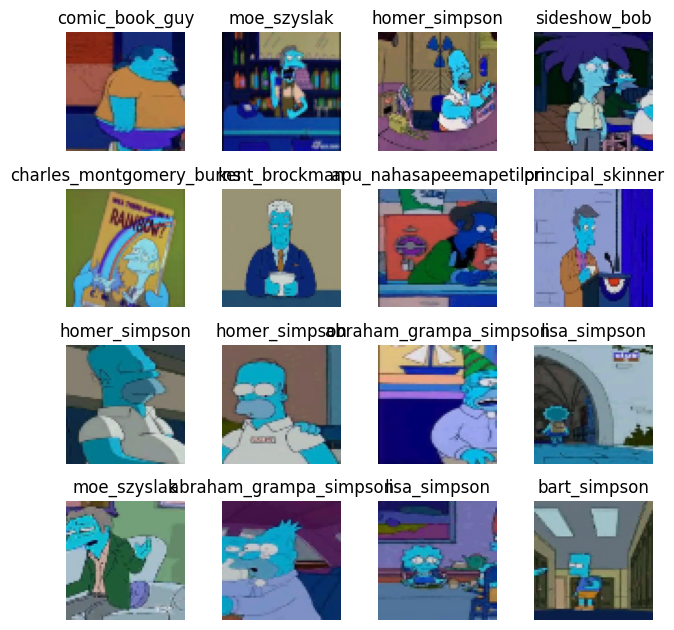

In [ ]:
h = 4  # alto de la grilla
w = 4  # ancho de la grilla
fig, axs = plt.subplots(h, w, figsize=(1.6*h, 1.6*w))
for i in range(h):
    for j in range(w):
        ex = np.random.randint(len(X_test))
        axs[i, j].imshow(X_test[ex])
        axs[i, j].set_title(MAP_CHARACTERS[y_test[ex]])
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()

## Normalización

In [ ]:
# Normaliza las imágenes (pasa de [0, 255] a [0.0, 1.0])
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Convierte las etiquetas a one-hot encoding
Y_train = keras.utils.to_categorical(y_train, num_categ)
Y_val = keras.utils.to_categorical(y_val, num_categ)
Y_test = keras.utils.to_categorical(y_test, num_categ)

print(X_train.shape, X_val.shape, X_test.shape)
print(Y_train.shape, Y_val.shape, Y_test.shape)

(32342, 64, 64, 3) (8086, 64, 64, 3) (890, 64, 64, 3)
(32342, 18) (8086, 18) (890, 18)


La normalización permite llevar los valores de los datos a una escala mucho menor (dividiendo por 255), lo que evita que existan valores excesivamente altos o bajos. De esta manera, todos los datos quedan en un formato uniforme y adecuado para el entrenamiento del modelo.

# Creación y entrenamiento de modelos


Para la creación de las redes neuronales convolucionales se utilizaran las siguientes herramientas, proporcionadas por la libreria de keras y tensorflow:

- Capa convolucional: Permitira mediante la utilizacion de un kernel redimensionar la imagen en busqueda de rescatar las caracteristicas relevantes para el modelo.

- Capa pool: Reduce la dimension de las caracteristicas (feature map) que entrega la capa de convolucion manteniendo asi unicamente las caracteristicas relevantes. Esto servira para evitar el sobre entrenamiento y mejorar el rendimiento, en cuanto a tiempo de ejecucion.

- Dropout: Permitira apagar cierto porcentaje de neuronas permitiendo asi que, en cada epoca, sea un numero de neuronas diferentes las que esten presentes en el entrenamiento y evitando asi que hayan neuronas que no presenten entrenamiento alguno.

- Red neuronal estandar (Feed forward): Ademas de aplicar las capas convolucionales y de pooling, que estan orientadas a trabajar y procesar la informacion antes de pasarlo directamente a las capas densas y realizar la prediccion, se utilizara una arquitectura estandar de feed forward.

In [ ]:
# Seteamos la semilla random
np.random.seed(29)
tf.random.set_seed(29)

hist = {}

La semilla aleatoria permite que tanto NumPy como TensorFlow trabajen con los mismos valores iniciales (utilizando la semilla 29), lo que garantiza que, sin importar cuántas veces se ejecute el código, los resultados sean reproducibles y se utilicen los mismos valores en cada ejecución.

## Modelo Base

In [ ]:
red_conv = Sequential(name="Network1_CNN")

red_conv.add(Input(shape=(64, 64, 3), name="input"))

red_conv.add(Conv2D(128, kernel_size=3, activation='relu', padding='same', name="conv1"))
red_conv.add(MaxPool2D((2, 2), name="pool1"))

red_conv.add(Conv2D(64, kernel_size=3, activation='relu', padding='same', name="conv2"))
red_conv.add(MaxPool2D((2, 2), name="pool2"))

red_conv.add(Flatten(name="flatten"))
red_conv.add(Dense(128, activation='relu', name="dense1"))
red_conv.add(Dense(64, activation='relu', name="dense2"))
red_conv.add(Dense(18, activation='softmax', name="output"))

red_conv.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

hist[red_conv.name] = red_conv.fit(
    X_train,Y_train,
    batch_size=32,
    epochs=25,
    validation_data=(X_val,Y_val)
)

Epoch 1/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.3453 - loss: 2.1509 - val_accuracy: 0.6295 - val_loss: 1.2456
Epoch 2/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.6623 - loss: 1.1467 - val_accuracy: 0.7026 - val_loss: 0.9882
Epoch 3/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.7564 - loss: 0.8074 - val_accuracy: 0.7357 - val_loss: 0.8961
Epoch 4/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8129 - loss: 0.6100 - val_accuracy: 0.7467 - val_loss: 0.9054
Epoch 5/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8590 - loss: 0.4539 - val_accuracy: 0.7471 - val_loss: 1.0216
Epoch 6/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.8940 - loss: 0.3393 - val_accuracy: 0.7566 - val_loss: 1.0282
Epoch 7/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.9072 - loss: 0.2864 - val_accuracy: 0.7560 - val_loss: 1.1205
Epoch 8/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9292 -

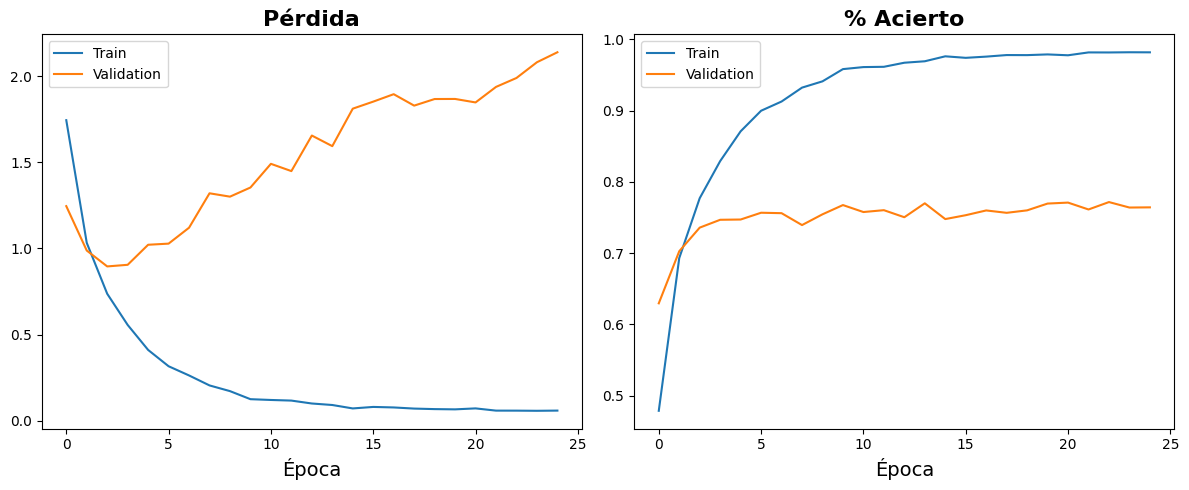

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas
# Gráfico de pérdida
axs[0].plot(hist[red_conv.name].history['loss'], label="Train")
axs[0].plot(hist[red_conv.name].history['val_loss'], label="Validation")
axs[0].set_title('Pérdida', fontsize=16, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=14)
axs[0].legend()

# Gráfico de precisión
axs[1].plot(hist[red_conv.name].history['accuracy'], label="Train")
axs[1].plot(hist[red_conv.name].history['val_accuracy'], label="Validation")
axs[1].set_title('% Acierto', fontsize=16, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=14)
axs[1].legend()

plt.tight_layout()
plt.show()

Como se puede observar en el gráfico, el modelo presenta una pérdida bastante elevada y una precisión en testing (val_accuracy) muy baja en comparación con la precisión en training, lo que indica un alto sobreajuste.

Tomando esto como el punto de partida (modelo base), se buscará en las próximas variantes reducir el sobreajuste sin sacrificar la alta precisión del modelo en training.

Los factores que se tomaron en cuenta como posibles causantes del sesgo son los siguientes:

- Dependencia neuronal (las neuronas aprenden patrones específicos y tienden a memorizar).

- Extracción de características simple.

- Alta dimensionalidad de las características.

## Modelo 2

In [ ]:
red_conv2 = Sequential(name="Network2_CNN")

red_conv2.add(Input(shape=(64, 64, 3), name="input"))

red_conv2.add(Conv2D(32, kernel_size=3, activation='relu', padding='same', name="conv1"))
red_conv2.add(Conv2D(32, kernel_size=3, activation='relu', padding='valid', name="conv2"))
red_conv2.add(tf.keras.layers.Dropout(0.2))
red_conv2.add(MaxPool2D((2, 2), name="pool1"))

red_conv2.add(Conv2D(64, kernel_size=3, activation='relu', padding='same', name="conv3"))
red_conv2.add(Conv2D(64, kernel_size=3, activation='relu', padding='valid', name="conv4"))
red_conv2.add(tf.keras.layers.Dropout(0.2))
red_conv2.add(MaxPool2D((2, 2), name="pool2"))

red_conv2.add(Flatten(name="flatten"))
red_conv2.add(Dense(128, activation='relu', name="dense1"))
red_conv2.add(tf.keras.layers.Dropout(0.2))
red_conv2.add(Dense(64, activation='relu', name="dense2"))
red_conv2.add(tf.keras.layers.Dropout(0.2))
red_conv2.add(Dense(64, activation='relu', name="dense3"))
red_conv2.add(tf.keras.layers.Dropout(0.2))
red_conv2.add(Dense(18, activation='softmax', name="output"))

red_conv2.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

hist[red_conv2.name] = red_conv2.fit(
    X_train,Y_train,
    batch_size=32,
    epochs=25,
    validation_data=(X_val,Y_val)
)

Epoch 1/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - accuracy: 0.2033 - loss: 2.5337 - val_accuracy: 0.5459 - val_loss: 1.6968
Epoch 2/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.5303 - loss: 1.5426 - val_accuracy: 0.6928 - val_loss: 1.1235
Epoch 3/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.6602 - loss: 1.1077 - val_accuracy: 0.7420 - val_loss: 0.9205
Epoch 4/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.7274 - loss: 0.8741 - val_accuracy: 0.7700 - val_loss: 0.8005
Epoch 5/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.7805 - loss: 0.7343 - val_accuracy: 0.7907 - val_loss: 0.7143
Epoch 6/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.8108 - loss: 0.6208 - val_accuracy: 0.8093 - val_loss: 0.6374
Epoch 7/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.8333 - loss: 0.5356 - val_accuracy: 0.8068 - val_loss: 0.6512
Epoch 8/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.8596 -

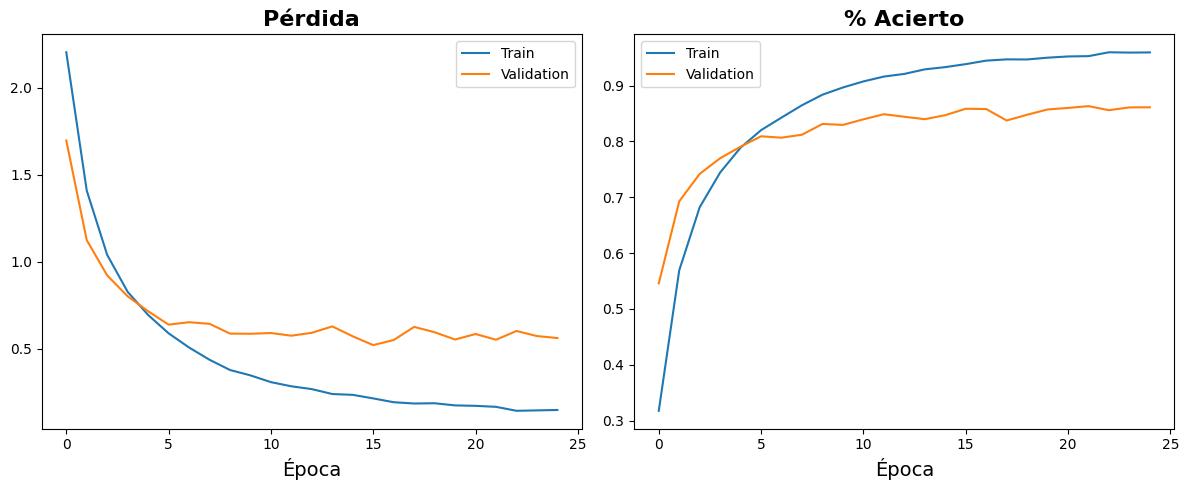

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas
# Gráfico de pérdida
axs[0].plot(hist[red_conv2.name].history['loss'], label="Train")
axs[0].plot(hist[red_conv2.name].history['val_loss'], label="Validation")
axs[0].set_title('Pérdida', fontsize=16, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=14)
axs[0].legend()

# Gráfico de precisión
axs[1].plot(hist[red_conv2.name].history['accuracy'], label="Train")
axs[1].plot(hist[red_conv2.name].history['val_accuracy'], label="Validation")
axs[1].set_title('% Acierto', fontsize=16, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=14)
axs[1].legend()

plt.tight_layout()
plt.show()

Como se puede observar en el gráfico, el sesgo se redujo un poco con la nueva arquitectura de la red. Aun así, sigue presente un sesgo que debe ser tratado. Los cambios realizados en la arquitectura fueron los siguientes:

- Se añadió una capa de convolución antes de cada pooling (dejando un total de 4 capas en lugar de 2). Esto permitirá que las neuronas de la capa convolucional puedan extraer patrones más complejos al trabajar sobre el mapeo de la capa anterior.

- Se añadió dropout (apagado de neuronas) antes de cada pooling, con el objetivo de evitar una alta dependencia neuronal, es decir, prevenir que las neuronas aprendan patrones fijos y comiencen a memorizar.

## Modelo 3

In [ ]:
red_conv3 = Sequential(name="Network3_CNN")

red_conv3.add(Input(shape=(64, 64, 3), name="input"))

red_conv3.add(Conv2D(32, kernel_size=3, activation='relu', padding='same', name="conv1"))
red_conv3.add(MaxPool2D((2, 2), name="pool1"))
red_conv3.add(Conv2D(32, kernel_size=3, activation='relu', padding='valid', name="conv2"))
red_conv3.add(tf.keras.layers.Dropout(0.2))
red_conv3.add(MaxPool2D((2, 2), name="pool2"))

red_conv3.add(Conv2D(64, kernel_size=3, activation='relu', padding='same', name="conv3"))
red_conv3.add(Conv2D(64, kernel_size=3, activation='relu', padding='valid', name="conv4"))
red_conv3.add(tf.keras.layers.Dropout(0.2))
red_conv3.add(MaxPool2D((2, 2), name="pool3"))

red_conv3.add(Flatten(name="flatten"))
red_conv3.add(Dense(128, activation='relu', name="dense1"))
red_conv3.add(tf.keras.layers.Dropout(0.2))
red_conv3.add(Dense(64, activation='relu', name="dense2"))
red_conv3.add(tf.keras.layers.Dropout(0.2))
red_conv3.add(Dense(64, activation='relu', name="dense3"))
red_conv3.add(tf.keras.layers.Dropout(0.2))
red_conv3.add(Dense(64, activation='relu', name="dense4"))
red_conv3.add(tf.keras.layers.Dropout(0.2))
red_conv3.add(Dense(18, activation='softmax', name="output"))

red_conv3.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

hist[red_conv3.name] = red_conv3.fit(
    X_train,Y_train,
    batch_size=32,
    epochs=25,
    validation_data=(X_val,Y_val)
)

Epoch 1/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.1300 - loss: 2.7174 - val_accuracy: 0.3532 - val_loss: 2.0211
Epoch 2/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.4106 - loss: 1.8186 - val_accuracy: 0.6198 - val_loss: 1.2826
Epoch 3/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6009 - loss: 1.2750 - val_accuracy: 0.7130 - val_loss: 0.9646
Epoch 4/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6754 - loss: 1.0313 - val_accuracy: 0.7587 - val_loss: 0.7909
Epoch 5/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7310 - loss: 0.8627 - val_accuracy: 0.7738 - val_loss: 0.7295
Epoch 6/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7664 - loss: 0.7454 - val_accuracy: 0.7884 - val_loss: 0.6636
Epoch 7/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.7868 - loss: 0.6841 - val_accuracy: 0.7895 - val_loss: 0.6925
Epoch 8/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8129 - loss: 0.6

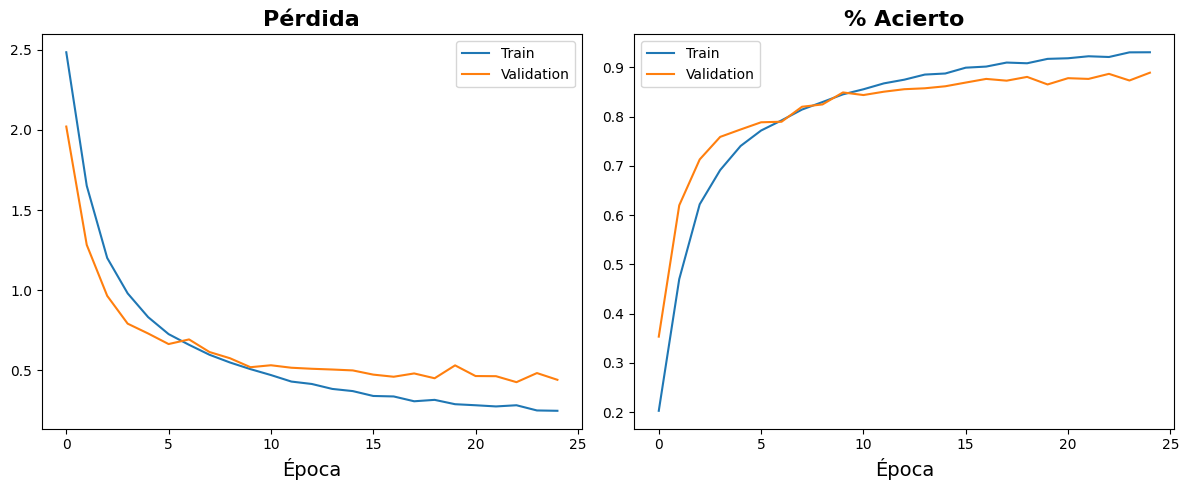

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas
# Gráfico de pérdida
axs[0].plot(hist[red_conv3.name].history['loss'], label="Train")
axs[0].plot(hist[red_conv3.name].history['val_loss'], label="Validation")
axs[0].set_title('Pérdida', fontsize=16, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=14)
axs[0].legend()

# Gráfico de precisión
axs[1].plot(hist[red_conv3.name].history['accuracy'], label="Train")
axs[1].plot(hist[red_conv3.name].history['val_accuracy'], label="Validation")
axs[1].set_title('% Acierto', fontsize=16, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=14)
axs[1].legend()

plt.tight_layout()
plt.show()

En este experimento, como se puede observar en el gráfico, se logró reducir un poco más el sobreajuste que presenta la red neuronal. Esta vez, los cambios que se realizaron en la arquitectura fueron los siguientes:

- Se añadió un pooling después de la primera capa convolucional, con el objetivo de reducir la dimensionalidad del mapeo de características, disminuyendo así el consumo computacional y eliminando posibles características irrelevantes para las siguientes capas.

- Se añadió una capa densa más (haciendo un total de 4), con el propósito de aumentar la capacidad de modelado y la extracción de patrones más complejos por parte del modelo. Con la presencia de dropout, se evita la dependencia neuronal por parte de las neuronas en las capas densas.

## Modelo 4

In [ ]:
red_conv4 = Sequential(name="Network4_CNN")

red_conv4.add(Input(shape=(64, 64, 3), name="input"))

red_conv4.add(Conv2D(64, kernel_size=3, activation='relu', padding='same', name="conv1"))
red_conv4.add(tf.keras.layers.Dropout(0.2))
red_conv4.add(MaxPool2D((2, 2), name="pool1"))

red_conv4.add(Conv2D(64, kernel_size=3, activation='relu', padding='valid', name="conv2"))
red_conv4.add(tf.keras.layers.Dropout(0.2))
red_conv4.add(MaxPool2D((2, 2), name="pool2"))

red_conv4.add(Conv2D(32, kernel_size=3, activation='relu', padding='same', name="conv3"))
red_conv4.add(tf.keras.layers.Dropout(0.2))
red_conv4.add(MaxPool2D((2, 2), name="pool3"))

red_conv4.add(Conv2D(32, kernel_size=3, activation='relu', padding='valid', name="conv4"))
red_conv4.add(tf.keras.layers.Dropout(0.2))
red_conv4.add(MaxPool2D((2, 2), name="pool4"))

red_conv4.add(Flatten(name="flatten"))
red_conv4.add(Dense(128, activation='relu', name="dense1"))
red_conv4.add(tf.keras.layers.Dropout(0.2))
red_conv4.add(Dense(64, activation='relu', name="dense2"))
red_conv4.add(tf.keras.layers.Dropout(0.2))
red_conv4.add(Dense(64, activation='relu', name="dense3"))
red_conv4.add(tf.keras.layers.Dropout(0.2))
red_conv4.add(Dense(64, activation='relu', name="dense4"))
red_conv4.add(tf.keras.layers.Dropout(0.2))
red_conv4.add(Dense(18, activation='softmax', name="output"))

red_conv4.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

hist[red_conv4.name] = red_conv4.fit(
    X_train,Y_train,
    batch_size=32,
    epochs=25,
    validation_data=(X_val,Y_val)
)

Epoch 1/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.1120 - loss: 2.7361 - val_accuracy: 0.3923 - val_loss: 2.0551
Epoch 2/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.4176 - loss: 1.8456 - val_accuracy: 0.5805 - val_loss: 1.5115
Epoch 3/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.5448 - loss: 1.4624 - val_accuracy: 0.6300 - val_loss: 1.2402
Epoch 4/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.6112 - loss: 1.2582 - val_accuracy: 0.6644 - val_loss: 1.1101
Epoch 5/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6589 - loss: 1.1062 - val_accuracy: 0.7147 - val_loss: 0.9986
Epoch 6/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.6879 - loss: 1.0261 - val_accuracy: 0.7420 - val_loss: 0.8773
Epoch 7/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.7215 - loss: 0.9178 - val_accuracy: 0.7619 - val_loss: 0.8298
Epoch 8/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7434 - loss: 0.85

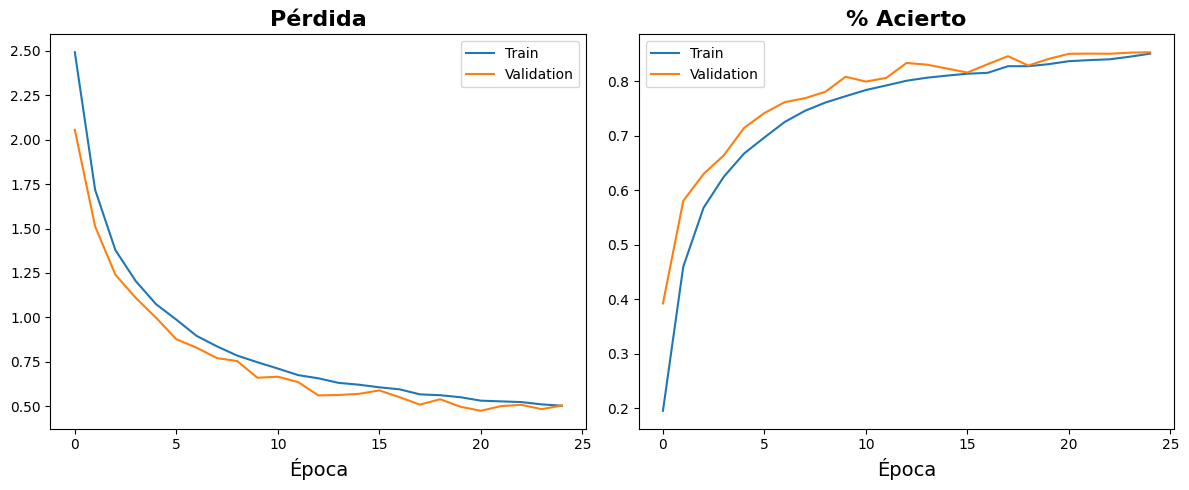

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas
# Gráfico de pérdida
axs[0].plot(hist[red_conv4.name].history['loss'], label="Train")
axs[0].plot(hist[red_conv4.name].history['val_loss'], label="Validation")
axs[0].set_title('Pérdida', fontsize=16, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=14)
axs[0].legend()

# Gráfico de precisión
axs[1].plot(hist[red_conv4.name].history['accuracy'], label="Train")
axs[1].plot(hist[red_conv4.name].history['val_accuracy'], label="Validation")
axs[1].set_title('% Acierto', fontsize=16, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=14)
axs[1].legend()

plt.tight_layout()
plt.show()

Como se puede observar en el gráfico, el sesgo presente se redujo de forma muy notable, llegando a ser casi inexistente; sin embargo, esto conllevó a sacrificar considerablemente la precisión del modelo. Habiendo reducido el sesgo a un nivel que no debería representar un problema, el siguiente objetivo será aumentar el rendimiento del modelo sin incrementar nuevamente el sesgo.

Los cambios realizados en esta variante fueron los siguientes:

- Se colocó un pooling entre cada capa convolucional, con el objetivo de reducir la dimensionalidad después de cada procesamiento de la capa convolucional. Esto disminuye notablemente el consumo computacional y, al mismo tiempo, permite tratar el mapeo de características, eliminando aquellas que resulten irrelevantes antes de pasar a la siguiente capa.

- Se añadió un dropout en cada capa convolucional, con el fin de asegurar que no exista dependencia neuronal en ninguna de las capas y evitar así que las neuronas aprendan patrones fijos y comiencen a memorizar en lugar de generalizar.

Con estos cambios, se logró una reducción significativa del sesgo, aunque a costa de una pérdida importante de precisión.

## Modelo 5

In [ ]:
red_conv5 = Sequential(name="Network5_CNN")

red_conv5.add(Input(shape=(64, 64, 3), name="input"))

red_conv5.add(Conv2D(64, kernel_size=3, activation='relu', padding='same', name="conv1"))
red_conv5.add(tf.keras.layers.Dropout(0.2))
red_conv5.add(MaxPool2D((2, 2), name="pool1"))

red_conv5.add(Conv2D(64, kernel_size=3, activation='relu', padding='valid', name="conv2"))
red_conv5.add(tf.keras.layers.Dropout(0.2))
red_conv5.add(MaxPool2D((2, 2), name="pool2"))

red_conv5.add(Conv2D(64, kernel_size=3, activation='relu', padding='valid', name="conv3"))
red_conv5.add(tf.keras.layers.Dropout(0.2))
red_conv5.add(MaxPool2D((2, 2), name="pool3"))

red_conv5.add(Conv2D(64, kernel_size=3, activation='relu', padding='valid', name="conv4"))
red_conv5.add(tf.keras.layers.Dropout(0.2))
red_conv5.add(MaxPool2D((2, 2), name="pool4"))

red_conv5.add(Flatten(name="flatten"))
red_conv5.add(Dense(128, activation='relu', name="dense1"))
red_conv5.add(tf.keras.layers.Dropout(0.2))
red_conv5.add(Dense(64, activation='relu', name="dense2"))
red_conv5.add(tf.keras.layers.Dropout(0.2))
red_conv5.add(Dense(64, activation='relu', name="dense3"))
red_conv5.add(tf.keras.layers.Dropout(0.2))
red_conv5.add(Dense(64, activation='relu', name="dense4"))
red_conv5.add(tf.keras.layers.Dropout(0.2))
red_conv5.add(Dense(18, activation='softmax', name="output"))

red_conv5.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

hist[red_conv5.name] = red_conv5.fit(
    X_train,Y_train,
    batch_size=32,
    epochs=25,
    validation_data=(X_val,Y_val)
)

Epoch 1/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.1216 - loss: 2.7091 - val_accuracy: 0.4055 - val_loss: 1.9849
Epoch 2/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.4143 - loss: 1.7477 - val_accuracy: 0.5939 - val_loss: 1.4103
Epoch 3/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.5828 - loss: 1.2807 - val_accuracy: 0.7095 - val_loss: 1.0721
Epoch 4/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.6813 - loss: 1.0039 - val_accuracy: 0.7747 - val_loss: 0.8272
Epoch 5/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.7377 - loss: 0.8498 - val_accuracy: 0.7916 - val_loss: 0.7464
Epoch 6/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.7751 - loss: 0.7372 - val_accuracy: 0.7994 - val_loss: 0.7149
Epoch 7/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.7947 - loss: 0.6868 - val_accuracy: 0.8180 - val_loss: 0.6191
Epoch 8/25
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8105 - loss:

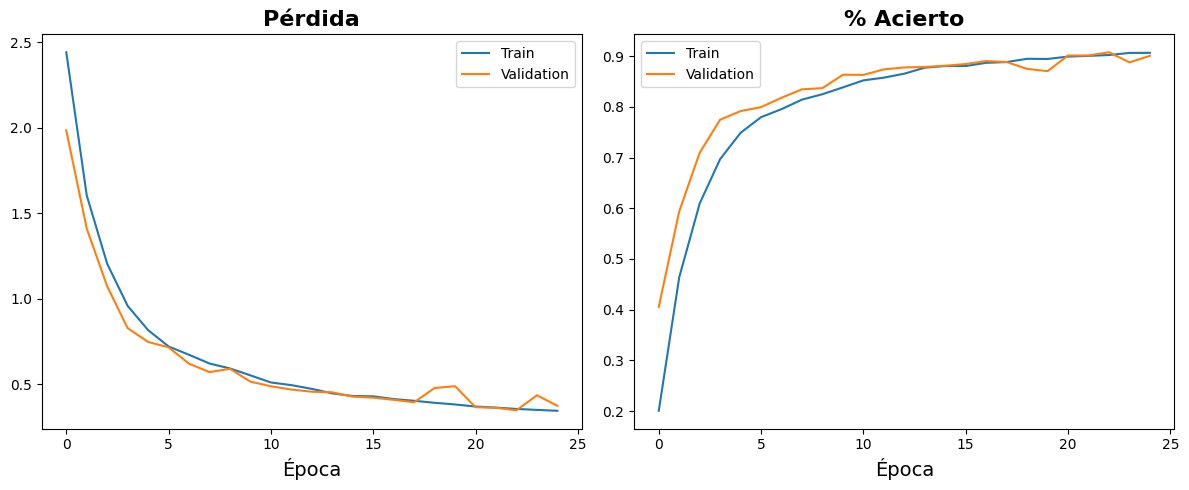

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 fila, 2 columnas
# Gráfico de pérdida
axs[0].plot(hist[red_conv5.name].history['loss'], label="Train")
axs[0].plot(hist[red_conv5.name].history['val_loss'], label="Validation")
axs[0].set_title('Pérdida', fontsize=16, fontweight="bold")
axs[0].set_xlabel('Época', fontsize=14)
axs[0].legend()

# Gráfico de precisión
axs[1].plot(hist[red_conv5.name].history['accuracy'], label="Train")
axs[1].plot(hist[red_conv5.name].history['val_accuracy'], label="Validation")
axs[1].set_title('% Acierto', fontsize=16, fontweight="bold")
axs[1].set_xlabel('Época', fontsize=14)
axs[1].legend()

plt.tight_layout()
plt.show()

En esta última variante se logró aumentar el rendimiento de manera notable sin incrementar la memorización (sesgo) del modelo. En este caso, los cambios en la arquitectura fueron mínimos, pero permitieron que el modelo detectara mejor los patrones dentro de las características que se le ingresaron. Los cambios realizados fueron los siguientes:

- Se aumentó la cantidad de neuronas en las capas convolucionales, considerando que en variantes anteriores, donde se realizaron cambios significativos en las capas convolucionales y/o en las capas de pooling, se tendió a reducir notablemente el sesgo. Esto sugiere que el problema principal del modelo podría encontrarse en el preprocesamiento de los datos (capas convolucionales y capas de pooling). Al aumentar la cantidad de neuronas en estas capas, se les permite detectar y procesar patrones más complejos. Además, con la presencia de dropout, se evita la dependencia neuronal, lo cual era casi seguro al prácticamente duplicar la cantidad de neuronas.

- Se cambió el tipo de padding a valid en todas las capas convolucionales, excepto en la primera. Esto permite que cada capa convolucional reduzca la dimensión de la imagen al eliminar los bordes, descartando así características que podrían ser innecesarias.

# Evaluacion de modelos

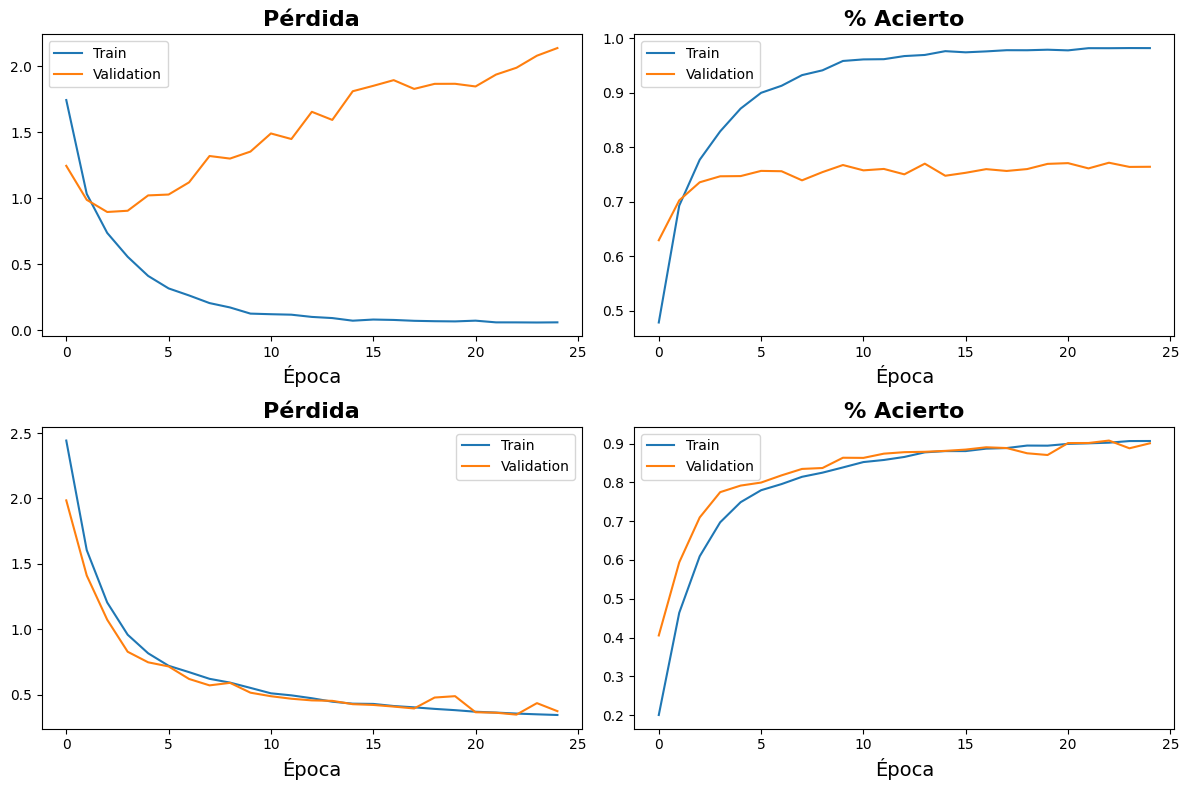

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # 1 fila, 2 columnas
# Gráfico de pérdida
axs[0, 0].plot(hist[red_conv.name].history['loss'], label="Train")
axs[0, 0].plot(hist[red_conv.name].history['val_loss'], label="Validation")
axs[0, 0].set_title('Pérdida', fontsize=16, fontweight="bold")
axs[0, 0].set_xlabel('Época', fontsize=14)
axs[0, 0].legend()

# Gráfico de precisión
axs[0, 1].plot(hist[red_conv.name].history['accuracy'], label="Train")
axs[0, 1].plot(hist[red_conv.name].history['val_accuracy'], label="Validation")
axs[0, 1].set_title('% Acierto', fontsize=16, fontweight="bold")
axs[0, 1].set_xlabel('Época', fontsize=14)
axs[0, 1].legend()

# Gráfico de pérdida
axs[1, 0].plot(hist[red_conv5.name].history['loss'], label="Train")
axs[1, 0].plot(hist[red_conv5.name].history['val_loss'], label="Validation")
axs[1, 0].set_title('Pérdida', fontsize=16, fontweight="bold")
axs[1, 0].set_xlabel('Época', fontsize=14)
axs[1, 0].legend()

# Gráfico de precisión
axs[1, 1].plot(hist[red_conv5.name].history['accuracy'], label="Train")
axs[1, 1].plot(hist[red_conv5.name].history['val_accuracy'], label="Validation")
axs[1, 1].set_title('% Acierto', fontsize=16, fontweight="bold")
axs[1, 1].set_xlabel('Época', fontsize=14)
axs[1, 1].legend()

plt.tight_layout()
plt.show()

In [ ]:
metrics = []

for name, history in hist.items():
  h = history.history
  metrics.append({
        'Model': name,
        'Final Accuracy': h['accuracy'][-1],
        'Final Val Accuracy': h['val_accuracy'][-1],
        'Final Loss': h['loss'][-1],
        'Final Val Loss': h['val_loss'][-1]
    })

df_summary = pd.DataFrame(metrics)

# Mostramos la tabla ordenada por Val Accuracy (opcional)
df_summary = df_summary.sort_values(by='Final Val Accuracy', ascending=False)

df_summary['Final Accuracy'] = df_summary['Final Accuracy'].apply(lambda x: f"{x * 100:.2f}%")
df_summary['Final Val Accuracy'] = df_summary['Final Val Accuracy'].apply(lambda x: f"{x * 100:.2f}%")

df_summary

,Model,Final Accuracy,Final Val Accuracy,Final Loss,Final Val Loss
4,Network5_CNN,90.65%,90.06%,0.343446,0.372798
2,Network3_CNN,93.06%,88.91%,0.247039,0.440452
1,Network2_CNN,95.96%,86.12%,0.146291,0.560185
3,Network4_CNN,85.10%,85.36%,0.503306,0.504426
0,Network1_CNN,98.17%,76.42%,0.060084,2.137803


En la tabla donde se realiza la comparación de rendimiento de los modelos, se puede observar que, si bien la variante número 5 (Network5_CNN) presenta un rendimiento general más bajo que las primeras variantes, la presencia de sesgo es prácticamente nula. Por lo tanto, se puede afirmar que el modelo está realizando una correcta generalización y es un candidato potencial.

# Conclusión y recomendaciones

Luego de la investigación, en la que se desarrollaron múltiples modelos en busca del mejor comportamiento con los datos proporcionados, se puede observar que el mejor modelo obtenido es Network5_CNN, ya que presenta un rendimiento general superior al 90% y una presencia de sesgo menor al 1%. Esto nos asegura que el modelo generaliza de manera adecuada.

Se recomienda realizar una experimentación más profunda en el diseño de la arquitectura con el objetivo de mejorar el rendimiento sin sacrificar la capacidad de generalización.

A continuación, se procederá a validar el modelo utilizando un conjunto de datos distinto al empleado durante su entrenamiento (una muestra que fue extraída de los datos originales antes de crear y entrenar los modelos).

In [ ]:
loss_red5, accuracy_red5 = red_conv5.evaluate(X_test, Y_test)

print("""
Test loss: {}
Test accuracy: {}
""".format(loss_red5, accuracy_red5))

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9482 - loss: 0.2345

Test loss: 0.22095023095607758
Test accuracy: 0.9505618214607239



Luego de realizar la evaluación, se puede observar que la precisión de la red con una muestra de validación es bastante alta. Esto refuerza lo que se había concluido en la comparación de los modelos: si bien Network5_CNN presenta un rendimiento general más bajo que otras variantes, posee una mayor capacidad de generalización, lo que le permite mantener un comportamiento aceptable frente a la mayoría de los datos que se le ingresen.